# Model Training and Selection

In this step, we compare three baseline models:
- Logistic Regression (linear baseline)
- K-Nearest Neighbors (non-parametric baseline)
- Simple Neural Network (nonlinear baseline)

The goal is **not to maximize accuracy** via hyperparameter tuning, but to ensure
each model achieves **reasonable predictive performance** before fairness analysis.

A well-performing yet interpretable model serves as the baseline for bias evaluation
across gender, race, and age groups.


In [21]:
# ======================================================
# Notebook 3: Model Training and Selection
# ======================================================

# Purpose:
# Use the cleaned dataset from Notebook 1 and the balancing insight (SMOTE)
# from Notebook 2 to train and evaluate models:
# Logistic Regression, KNN, and Neural Network (PyTorch).

# ------------------------------------------------------
# Imports
# ------------------------------------------------------
import os
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
)

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)


In [22]:
# ------------------------------------------------------
# 1. Load cleaned dataset
# ------------------------------------------------------
df = pd.read_csv("data/cleaned_diabetes_data.csv")
print("✅ Cleaned dataset loaded:", df.shape)
print("Class distribution:\n", df["diabetes"].value_counts(normalize=True))


✅ Cleaned dataset loaded: (100000, 19)
Class distribution:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [23]:
# ------------------------------------------------------
# 2. Train/test split
# ------------------------------------------------------
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Before SMOTE:", Counter(y_train))


Before SMOTE: Counter({0: 73200, 1: 6800})


In [24]:
# ------------------------------------------------------
# 3. Apply SMOTE to balance the training data
# ------------------------------------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_bal))


After SMOTE: Counter({1: 73200, 0: 73200})


In [25]:
# ------------------------------------------------------
# 4. Train Logistic Regression and KNN
# ------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    pipe.fit(X_train_bal, y_train_bal)
    y_pred = pipe.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "Balanced_Acc": balanced_accuracy_score(y_test, y_pred)
    })


NN Accuracy: 0.6928
NN Precision: 0.21105331599479843
NN Recall: 0.9547058823529412
NN F1: 0.34568690095846644


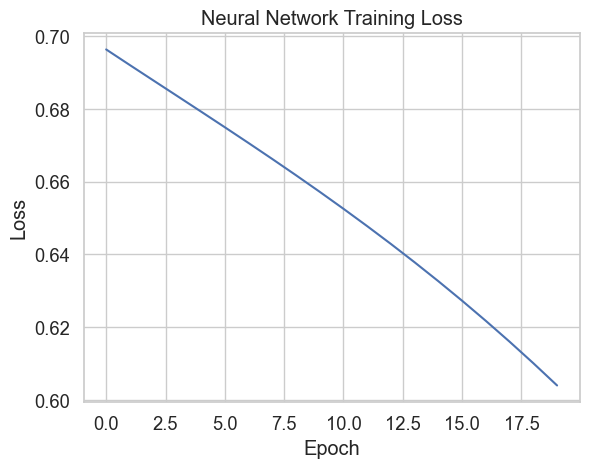

In [26]:
# ------------------------------------------------------
# 5. Train a simple Neural Network (PyTorch)
# ------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_bal.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

class DiabetesNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model_nn = DiabetesNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

epochs = 20
train_losses = []

for epoch in range(epochs):
    model_nn.train()
    optimizer.zero_grad()
    y_pred = model_nn(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

print("NN Accuracy:", accuracy_score(y_test, y_pred_labels))
print("NN Precision:", precision_score(y_test, y_pred_labels, zero_division=0))
print("NN Recall:", recall_score(y_test, y_pred_labels, zero_division=0))
print("NN F1:", f1_score(y_test, y_pred_labels, zero_division=0))


plt.plot(train_losses)
plt.title("Neural Network Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [27]:
# ------------------------------------------------------
# 6. Evaluate NN on test data
# ------------------------------------------------------
model_nn.eval()
with torch.no_grad():
    y_pred_nn = model_nn(X_test_t).numpy().flatten()
    y_pred_labels = (y_pred_nn >= 0.5).astype(int)

results.append({
    "Model": "Neural Network (PyTorch)",
    "Accuracy": accuracy_score(y_test, y_pred_labels),
    "Precision": precision_score(y_test, y_pred_labels, zero_division=0),
    "Recall": recall_score(y_test, y_pred_labels, zero_division=0),
    "F1": f1_score(y_test, y_pred_labels, zero_division=0),
    "Balanced_Acc": balanced_accuracy_score(y_test, y_pred_labels)
})


=== Model Comparison ===


,Model,Accuracy,Precision,Recall,F1,Balanced_Acc
0,Logistic Regression,0.88870,0.424857,0.874706,0.571923,0.882353
1,KNN,0.89705,0.440857,0.787059,0.565153,0.847163
2,Neural Network (PyTorch),0.77490,0.260922,0.899412,0.404497,0.831373


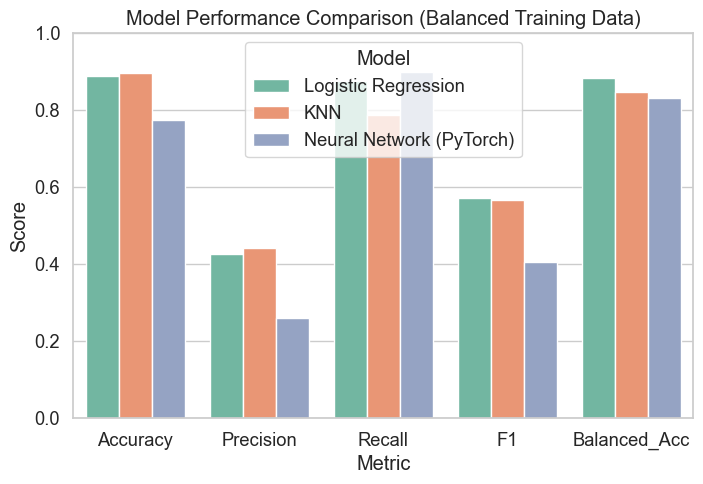

In [28]:
# ------------------------------------------------------
# 7. Compare results across all models
# ------------------------------------------------------
df_results = pd.DataFrame(results)
print("=== Model Comparison ===")
display(df_results)

plt.figure(figsize=(8,5))
df_melt = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("Model Performance Comparison (Balanced Training Data)")
plt.ylim(0, 1)
plt.show()


In [29]:
# ------------------------------------------------------
# 8. Save results for fairness analysis
# ------------------------------------------------------
os.makedirs("results", exist_ok=True)
df_results.to_csv("results/model_comparison.csv", index=False)

best_model = df_results.loc[df_results["Balanced_Acc"].idxmax(), "Model"]
print(f"✅ Model selected for fairness analysis: {best_model}")


✅ Model selected for fairness analysis: Logistic Regression


In [ ]:
~~ﬁ~~⁄~~~~